<a href="https://colab.research.google.com/github/eftekhar-hossain/Disaster_IEEE-Access/blob/main/damage_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [2]:
%%time
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json
from sklearn.metrics import confusion_matrix,classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from keras.utils.vis_utils import plot_model
np.random.seed(42)
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
import string, spacy,unicodedata, random
from bs4 import BeautifulSoup
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
import warnings
warnings.filterwarnings('ignore')
### Pretrained Word Embeddings
pretrained_path = "/content/drive/MyDrive/TaheriThesis/Dataset/PreTrained Wordembedding/"
# dataset_path = "/content/drive/MyDrive/Colab Notebooks/MSC Presentation Tasks/Disaster Response/Images/"
# folder_path = "/content/drive/MyDrive/Colab Notebooks/MSC Presentation Tasks/Disaster Response/"
models_path = "/content/drive/MyDrive/TaheriThesis/Dataset/Multimodal Sentiment/"


folder_path = "/content/drive/MyDrive/TaheriThesis/Dataset/"
# models_path = "/content/drive/MyDrive/TaheriThesis/Dataset/Multimodal Sentiment/Models/"
# results_path = "/content/drive/MyDrive/TaheriThesis/Dataset/Multimodal Sentiment/Results/"
dataset_path = "/content/drive/MyDrive/TaheriThesis/Dataset/Images/"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


CPU times: user 6.97 s, sys: 1.24 s, total: 8.21 s
Wall time: 13.7 s


In [3]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, GlobalAveragePooling2D, Embedding, LSTM, multiply
from keras.models import Model
from keras import preprocessing, Input
from tensorflow import keras
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
# from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from tensorflow.keras.models import load_model
import itertools
from PIL import Image, ImageFile
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D,MaxPooling1D,Conv1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Add, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Nadam
keras.backend.clear_session()

#Fetching Dataset

In [4]:
# train_data = pd.read_excel(folder_path+'train.xlsx')
# test_data = pd.read_csv(folder_path+'test.xlsx')
# valid_data = pd.read_excel(main_path+'valid_new.xlsx')
train_data = pd.read_csv(folder_path+'train.csv')
valid_data = pd.read_csv(folder_path+'val.csv')
test_data = pd.read_csv(folder_path+'test.csv')

In [5]:
train_data.columns

Index(['image_name', 'Captions', 'Label_Sentiment', 'Label'], dtype='object')

In [6]:
train_data['Label'].value_counts()

0    861
6    716
4    623
1    477
5    408
3    400
2    348
Name: Label, dtype: int64

In [7]:
test_data['Label'].value_counts()

0    93
6    79
4    68
5    46
3    44
1    44
2    40
Name: Label, dtype: int64

In [8]:
# train_data['enc_label'] = train_data['label'].replace({'non_damage':0,'damaged_infrastructure':1,'damaged_nature':2,
#                                                        'fires':3,'flood':4,'human_damage':5 })
# test_data['enc_label'] = test_data['label'].replace({'non_damage':0,'damaged_infrastructure':1,'damaged_nature':2,
#                                                      'fires':3,'flood':4,'human_damage':5 })


train_data['enc_label'] = train_data['Label_Sentiment'].replace({'happy':0,'angry':1,'disgust':2,'fear':3,'sad':4,'surprise':5,'other':6})
valid_data['enc_label'] = valid_data['Label_Sentiment'].replace({'happy':0,'angry':1,'disgust':2,'fear':3,'sad':4,'surprise':5,'other':6})



In [9]:
test_data['enc_label'] = test_data['Label_Sentiment'].replace({'happy':0,'angry':1,'disgust':2,'fear':3,'sad':4,'surprise':5,'other':6})

In [10]:
print("Size of the training data ==> ", train_data.shape)
print("Size of the training data ==> ", valid_data.shape)
print("Size of the Test data ==>", test_data.shape)

Size of the training data ==>  (3833, 5)
Size of the training data ==>  (414, 5)
Size of the Test data ==> (414, 5)


## Image Fetching

In [14]:
## collect image names from the folders
def create_img_array(img_dirct):
    all_imgs = []
    for root, j, files in os.walk(img_dirct):
        for file in files:
            file = root + '' + file
            all_imgs.append(file)
    return all_imgs

def create_img_path(DF, Col_name, img_dir):
    img_path = [img_dir + '' + name for name in DF[Col_name]]
    return img_path

In [ ]:
# Creating train, test and validation image path
train_img_path = create_img_path(train_data,'image_name', dataset_path)
valid_img_path = create_img_path(valid_data,'image_name', dataset_path)


In [15]:
test_img_path = create_img_path(test_data,'image_name', dataset_path)

In [16]:
# Function that returns image reading from the path
def get_input(path):
    # Loading image from given path
    # and resizing it to 150*150*3 format
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    img= tf.keras.utils.load_img(path, target_size=(150,150)) 
    # img.close()   
    return(img)

# Takes in image and preprocess it
def process_input(img):
    # Converting image to array    
    img_data =tf.keras.utils.img_to_array(img)
    # Adding one more dimension to array    
    img_data = np.expand_dims(img_data, axis=0)
    #     
    img_data = preprocess_input(img_data)
    #img_data = preprocess_input(img_data)
    return(img_data)


In [ ]:
# Create an array of training images
train_images = []
for n,i in enumerate(train_img_path):
  input_img = get_input(i)
  process_img = process_input(input_img)
  # print(n)
  train_images.append(process_img[0])

In [ ]:
# Create an array of training images
valid_images = []
for n,i in enumerate(valid_img_path):
  input_img = get_input(i)
  process_img = process_input(input_img)
  # print(n)
  valid_images.append(process_img[0])

In [17]:
# Create an array of training images
test_images = []
for n,i in enumerate(test_img_path):
  input_img = get_input(i)
  process_img = process_input(input_img)
  # print(n)
  test_images.append(process_img[0])


In [ ]:
# convert into numpy array
train_image = np.array(train_images)
# convert into numpy array


In [ ]:
valid_image = np.array(valid_images)

In [18]:
test_image = np.array(test_images)

In [ ]:
import pickle as pkl
with open(dataset_path+'train.pkl','wb') as f:
    pkl.dump(train_image, f)

# with open(dataset_path+'test.pkl','wb') as f:
#     pkl.dump(test_image, f)    

In [ ]:
import pickle as pkl
with open(dataset_path+'valid.pkl','wb') as f:
    pkl.dump(valid_image, f)

In [19]:
import pickle as pkl


with open(dataset_path+'test.pkl','wb') as f:
    pkl.dump(test_image, f)    

In [ ]:


with open(dataset_path+'train.pkl','rb') as f:
  train_image = pkl.load(f)
  print("Training Images:-- ",train_image.shape)

    

Training Images:--  (3833, 150, 150, 3)


In [ ]:

with open(dataset_path+'valid.pkl','rb') as f:
  valid_image = pkl.load(f)
  print("Validation Images:-- ",valid_image.shape)

Validation Images:--  (414, 150, 150, 3)


In [20]:
with open(dataset_path+'test.pkl','rb') as f:
  test_image = pkl.load(f)
  print("Test Images:-- ",test_image.shape)

Test Images:--  (414, 150, 150, 3)


## One Hot Encoding

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# encoder=OneHotEncoder(sparse=False)

# encoded_labels = pd.DataFrame (encoder.fit_transform(train_data[['label']]))

# encoded_labels .columns = encoder.get_feature_names(['label'])

# train_data= pd.concat([train_data, encoded_labels ], axis=1)

import pandas as pd

# Define the list of categories for your Label_Sentiment variable
categories = ['happy', 'angry', 'disgust', 'fear', 'sad', 'surprise', 'other']

# Perform one-hot encoding using get_dummies() function
encoded_labels = pd.get_dummies(train_data['Label_Sentiment'], columns=categories, prefix='Label_Sentiment')

# Concatenate the encoded labels with your original train_data DataFrame
train_data = pd.concat([train_data, encoded_labels], axis=1)

In [ ]:
train_data.columns

Index(['image_name', 'Captions', 'Label_Sentiment', 'Label', 'enc_label',
       'Label_Sentiment_angry', 'Label_Sentiment_disgust',
       'Label_Sentiment_fear', 'Label_Sentiment_happy',
       'Label_Sentiment_other', 'Label_Sentiment_sad',
       'Label_Sentiment_surprise'],
      dtype='object')

In [ ]:
# train_data = train_data.rename(columns={'label_damaged_infrastructure':'damaged_infrastructure', 'label_damaged_nature':'damaged_nature', 
#                                         'label_fires':'fires','label_flood':'flood',
#                                         'label_human_damage':'human_damage', 'label_non_damage':'non_damage'})


train_data = train_data.rename(columns={'Label_Sentiment_happy':'happy', 
                                        'Label_Sentiment_angry':'angry',
                                        'Label_Sentiment_disgust':'disgust',
                                        'Label_Sentiment_fear':'fear',
                                        'Label_Sentiment_sad':'sad',
                                        'Label_Sentiment_surprise':'surprise',
                                        'Label_Sentiment_other':'other'})
     

train_data

,image_name,Captions,Label_Sentiment,Label,enc_label,angry,disgust,fear,happy,other,sad,surprise
0,205.jpg,নির্বোধ দেখার এবং আপনি যে যত্নশীল তা না করার ক...,other,6,6,0,0,0,0,1,0,0
1,209.jpg,একটি বোর্ডার আর্ম স্কেটার একটি আমন্ত্রণ উপার্জ...,other,6,6,0,0,0,0,1,0,0
2,210.jpg,যদি শরীর দুর্বল হয় তবে মন শক্তিশালী হবে না।,other,6,6,0,0,0,0,1,0,0
3,215.jpg,একজন ধার্মিক ব্যক্তির কার্যকর উত্সাহ প্রার্থনা...,other,6,6,0,0,0,0,1,0,0
4,222.jpg,অসমাপ্ত ?,other,6,6,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3828,4676.jpg,অভিনন্দন ২ প্রথম আইবিএম প্যাথওয়েসটেক পণ্ডিতরা...,happy,0,0,0,0,0,1,0,0,0
3829,4677.jpg,সবেমাত্র আমার চুলের সাথে রুটোশায়ার স্ক্যাল্প ...,happy,0,0,0,0,0,1,0,0,0
3830,4678.jpg,সবেমাত্র এই ওক ড্রেসারটি শেষ করেছেন।,happy,0,0,0,0,0,1,0,0,0
3831,4682.jpg,সুগারম্যান রজার্স মামলা-মোকদ্দমা কেমব্রিজে গত ...,happy,0,0,0,0,0,1,0,0,0


In [ ]:
train_data.columns

Index(['image_name', 'Captions', 'Label_Sentiment', 'Label', 'enc_label',
       'angry', 'disgust', 'fear', 'happy', 'other', 'sad', 'surprise'],
      dtype='object')

In [ ]:
train_data.Captions = train_data.Captions.astype(str)

##Evaluation Metrics

In [27]:
'''Evaluation Parameters'''

def print_metrices(true,pred):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred))
    print("Accuracy : ",accuracy_score(true,pred))
    print("Precison : ",precision_score(true,pred, average = 'weighted'))
    print("Recall : ",recall_score(true,pred,  average = 'weighted'))
    print("F1 : ",f1_score(true,pred,  average = 'weighted'))

## Confusion Matrix

In [28]:
## Confusion matrix function
def con_mat(true,pred,class_names,model_name):
  cm = confusion_matrix(true,pred)
  #sns.set()
  plt.figure(figsize =(4, 3))
  ax = plt.subplot()
 # 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            #'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
  sns.heatmap(cm, annot=True,fmt="d",cmap='YlOrRd', ax = ax,annot_kws={"size": 10},) #annot=True to annotate cells
  # labels, title and ticks
  ax.set_xlabel('Predicted labels',fontsize=10)
  ax.set_ylabel('True labels',fontsize=10) 
  #ax.set_title(f'Confusion Matrix of {model_name}',fontsize=10) 
  ax.xaxis.set_ticklabels(class_names, rotation=45); ax.yaxis.set_ticklabels(class_names, rotation=45);
  ax.xaxis.tick_top()
 # plt.savefig(folder_path + f"{model_name}.png",bbox_inches='tight',dpi =500)

In [11]:
from sklearn.utils import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_data['enc_label']),
                                        y = train_data['enc_label']                                                   
                                    )
class_weights = dict(zip(np.unique(train_data['enc_label']), class_weights))
class_weights

{0: 0.6359714617554338,
 1: 1.147948487571129,
 2: 1.5734811165845648,
 3: 1.3689285714285715,
 4: 0.881757533931447,
 5: 1.3355400696864113,
 6: 0.7647645650438947}

## Callbacks

In [ ]:
''' Callbacks'''
keras.backend.clear_session()
def callbacks_check(model_name):
  num_classes = 7
  accuracy_threshold = 0.99

  class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>accuracy_threshold):
          print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
          self.model.stop_training = True

  acc_callback = myCallback()
  # Saved the Best Model
  filepath = models_path+'Models_2/'+f"{model_name}.h5"
  checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
  # callback list
  callback_list = [acc_callback, checkpoint] 

  return callback_list

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(train_data['enc_label'])
y_valid=to_categorical(valid_data['enc_label'])

In [ ]:
from tensorflow.keras.utils import to_categorical
y_test=to_categorical(test_data['enc_label'])

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#Visual Models

In [ ]:
keras.backend.clear_session()

def visual_models():


  #### Resnet
  resnet = ResNet50(weights='imagenet', include_top=False,input_shape=(150, 150, 3))
  #resnet.trainable = False
  for layer in resnet.layers[0:-10]:
      layer.trainable = False
  # add a global spatial average pooling layer
  y = resnet.output
  pool1 = GlobalAveragePooling2D()(y)
  # let's add a fully-connected layer
  #flat1 = Flatten()(pool1)
  # and a logistic layer -- let's say we have 200 classes
  #hidden = Dense(512, activation='relu')(flat1)
  #dropout1 = Dropout(0.1)(hidden)
  output1 = Dense(7, activation='softmax')(pool1)
  # this is the model we will train
  resnet_img_model = Model(inputs=resnet.input, outputs=output1)




  models = [resnet_img_model]

  return models


In [ ]:
model_name = ['resnet']
list_model = visual_models()

for mn,model in enumerate(list_model):

  model.compile(loss='categorical_crossentropy', 
                      optimizer=Adam()
, 
                      metrics = ["accuracy"])
  print(f"Model Name: {model_name[mn]}\n")
  # Training model
  model.fit(x=train_image, 
              y=y_train,
              epochs=30, 
              batch_size =32,
              validation_data=(valid_image,y_valid),
              verbose = 1,
              class_weight = class_weights,
              callbacks = callbacks_check(model_name[mn])
              )

29084464/29084464 [==============================] - 2s 0us/step
Model Name: vgg16

Epoch 1/30
  6/120 [>.............................] - ETA: 22s - loss: 27.7359 - accuracy: 0.1875

120/120 [==============================] - ETA: 0s - loss: 3.2496 - accuracy: 0.2095
Epoch 1: val_accuracy improved from -inf to 0.26329, saving model to /content/drive/MyDrive/TaheriThesis/Dataset/Multimodal Sentiment/Models_2/vgg16.h5
120/120 [==============================] - 61s 323ms/step - loss: 3.2496 - accuracy: 0.2095 - val_loss: 1.9123 - val_accuracy: 0.2633
Epoch 2/30
120/120 [==============================] - ETA: 0s - loss: 1.9056 - accuracy: 0.2158
Epoch 2: val_accuracy did not improve from 0.26329
120/120 [==============================] - 24s 201ms/step - loss: 1.9056 - accuracy: 0.2158 - val_loss: 1.9078 - val_accuracy: 0.2222
Epoch 3/30
120/120 [==============================] - ETA: 0s - loss: 1.9013 - accuracy: 0.2220
Epoch 3: val_accuracy did not improve from 0.26329
120/120 [==============================] - 25s 207ms/step - loss: 1.9013 - accuracy: 0.2220 - val_loss: 1.9031 - val_accuracy: 0.2222
Epoch 4/30
120/120 [==============================] - ETA: 0s - los

## Visual Models Performance

In [12]:
visual_models = ['resnet',]
visual_model_names = ['ResNet']

def visual_models_accuracy(saved_model): 
  my_dict = {}
  # Prediction 
  model = load_model(models_path+'Models_2/'+f"{saved_model}.h5")
  y_pred = np.argmax(model.predict(test_image), axis=-1)

  y_true = test_data['enc_label']

  my_dict['Accuracy'] = accuracy_score(y_true, y_pred)*100
  my_dict['Precision'] = precision_score(y_true, y_pred,average = 'weighted')*100
  my_dict['Recall'] = recall_score(y_true, y_pred,average = 'weighted')*100 
  my_dict['F1 Score'] = f1_score(y_true, y_pred,average = 'weighted')*100 
  return my_dict

In [21]:
accuracy = {f'{visual_model_names[i]}':visual_models_accuracy(model) for i,model in enumerate(visual_models)}
# Save the performance parameter into json file
with open(models_path+'Results_2/'+'visual_models_performance.json', 'w') as f:
    json.dump(accuracy, f)


13/13 [==============================] - 19s 1s/step


In [24]:
# Load the json file
metrics = json.load(open(models_path+'Results_2/'+'visual_models_performance.json'))
acc_list = []
pr_list = []
re_list = []
f1_list = []
for i in metrics.keys():
  acc_list.append(round(metrics[i]['Accuracy'],2))
  pr_list.append(round(metrics[i]['Precision'],2))
  re_list.append(round(metrics[i]['Recall'],2))
  f1_list.append(round(metrics[i]['F1 Score'],2))

print (color.BOLD+f"=======  Visual Models Performance on Test Data  =============\n"+color.END)
# Create a dataframe
performance_matrix = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list},
                                  index =['ResNet'])
performance_matrix

=======  Visual Models Performance on Test Data  =============



,Accuracy,Precision,Recall,F1 Score
ResNet,70.53,73.36,70.53,70.36


## Confusion Matrix (Visual Models)

In [25]:
visual_models = ['resnet']
visual_model_names = ['ResNet']
class_names = ['happy','angry','disgust','fear','sad','surprise','other']
def visual_models_confusion_matrix(saved_model,model_name): 
   
  model = load_model(models_path+'Models_2/'+f"{saved_model}.h5")
  y_pred = np.argmax(model.predict(test_image), axis=-1)

  y_true = test_data['enc_label']
  con_mat(y_true,y_pred,class_names,model_name) 

======= Confusion Matrices for Visual Models  =============

13/13 [==============================] - 21s 2s/step


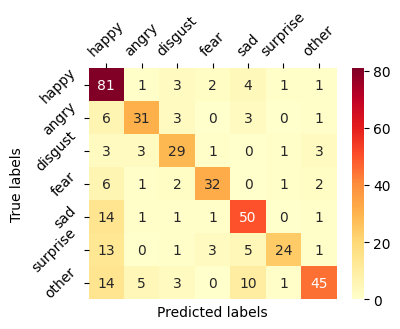

In [29]:
print (color.BOLD+f"======= Confusion Matrices for Visual Models  =============\n"+color.END)
for i,model in enumerate(visual_models):
  visual_models_confusion_matrix(model,visual_model_names[i])

In [30]:
visual_models = ['resnet']
visual_model_names = ['ResNet']
class_names = ['happy','angry','disgust','fear','sad','surprise','other']
def visual_models_metrics(saved_model,model_name): 
   
  model = load_model(models_path+'Models_2/'+f"{saved_model}.h5")
  y_pred = np.argmax(model.predict(test_image), axis=-1)

  y_true = test_data['enc_label']
  # con_mat(y_true,y_pred,class_names,model_name) 
  print_metrices(y_true,y_pred)

In [31]:
print (color.BOLD+f"======= Matrices for Visual Models  =============\n"+color.END)
for i,model in enumerate(visual_models):
  visual_models_metrics(model,visual_model_names[i])

======= Matrices for Visual Models  =============

13/13 [==============================] - 27s 2s/step
[[81  1  3  2  4  1  1]
 [ 6 31  3  0  3  0  1]
 [ 3  3 29  1  0  1  3]
 [ 6  1  2 32  0  1  2]
 [14  1  1  1 50  0  1]
 [13  0  1  3  5 24  1]
 [14  5  3  0 10  1 45]]
              precision    recall  f1-score   support

           0       0.59      0.87      0.70        93
           1       0.74      0.70      0.72        44
           2       0.69      0.72      0.71        40
           3       0.82      0.73      0.77        44
           4       0.69      0.74      0.71        68
           5       0.86      0.51      0.64        47
           6       0.83      0.58      0.68        78

    accuracy                           0.71       414
   macro avg       0.75      0.69      0.71       414
weighted avg       0.73      0.71      0.70       414

Accuracy :  0.7053140096618358
Precison :  0.7335534786608521
Recall :  0.7053140096618358
F1 :  0.7035722671065089


In [32]:
from sklearn.metrics import matthews_corrcoef

visual_models = [ 'resnet']
visual_model_names = [ 'ResNet']
class_names = ['happy', 'angry', 'disgust', 'fear', 'sad', 'surprise', 'other']

def visual_models_metrics_MCC(saved_model, model_name):
  model = load_model(models_path + 'Models_2/' + f"{saved_model}.h5")
  y_pred = np.argmax(model.predict(test_image), axis=-1)
  y_true = test_data['enc_label']

 

  # Calculate MCC
  mcc = matthews_corrcoef(y_true, y_pred)
  print(f"MCC for {model_name}: {mcc}")

print(f"{color.BOLD}======= Matrices for Visual Models  ============={color.END}")
for i, model in enumerate(visual_models):
  visual_models_metrics_MCC(model, visual_model_names[i])


======= Matrices for Visual Models  =============
13/13 [==============================] - 22s 2s/step
MCC for ResNet: 0.6535726347748353
